In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [26]:
Riyadh_weather = pd.read_csv("Riyadh_weather.csv")

In [27]:
import matplotlib.pyplot as plt
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [184]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [28]:
Riyadh_weather.head()

,date,Temperature_Max,Temperature_Avg,Temperature_Min,Dew_Point_Max,Dew_Point_Avg,Dew_Point_Min,Humidity_Max,Humidity_Min,Wind_speed_Max,Wind_speed_Min,Pressure_Max,Pressure_Min
0,2008-1-1,78,62,46,36,30,27,53,17,8,0,30.15,30.01
1,2008-1-2,80,68,55,39,33,30,41,20,14,4,30.06,29.95
2,2008-1-3,80,66,51,43,37,30,58,18,9,0,30.09,29.98
3,2008-1-4,71,65,59,57,45,36,82,37,13,0,30.09,29.98
4,2008-1-5,66,60,51,57,51,46,94,55,14,0,30.18,30.06


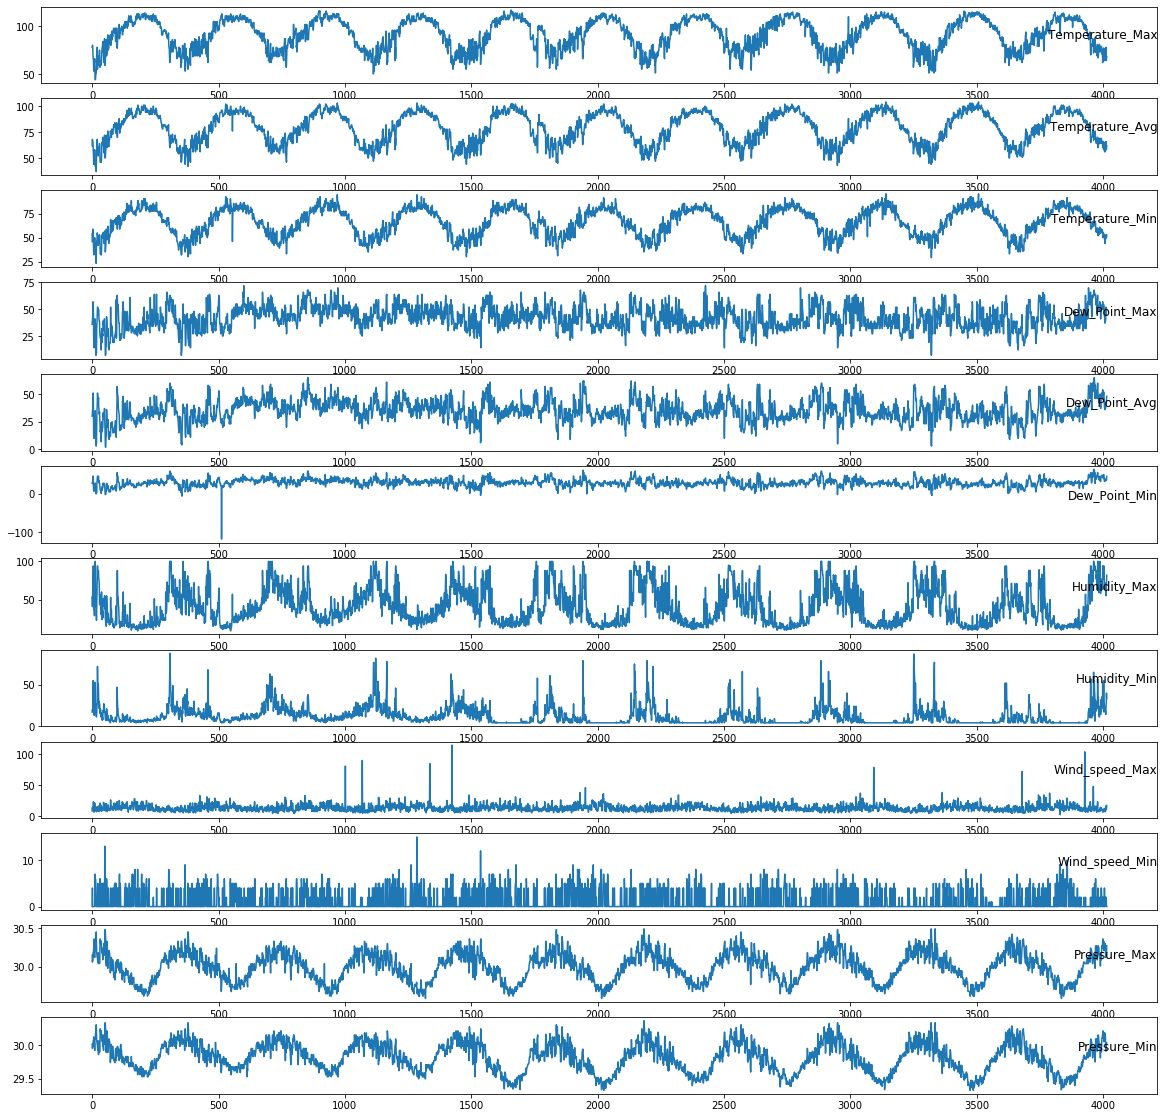

In [29]:
i=1
plt.figure(figsize=(20,20))
for col in Riyadh_weather.columns[1:]:
    plt.subplot(len(Riyadh_weather.columns[1:]), 1, i)
    plt.plot(Riyadh_weather[col])
    plt.title(col, y=0.5, loc='right')
    i += 1
plt.show()

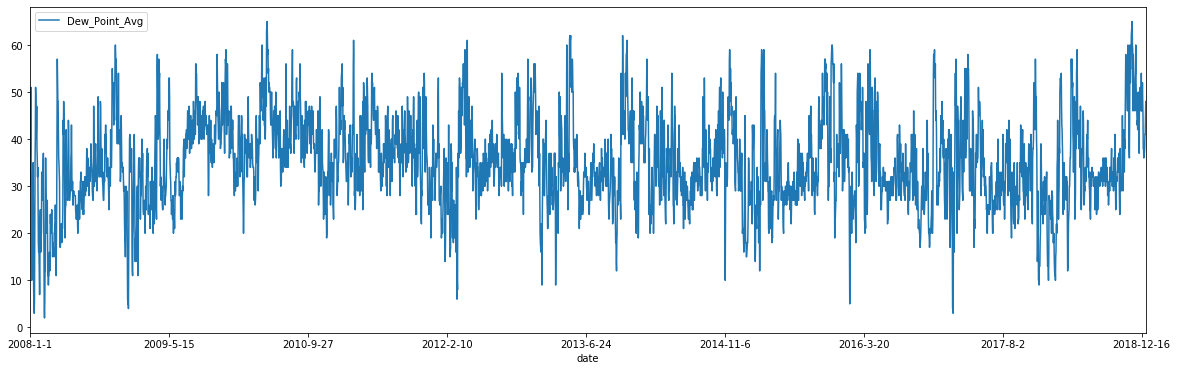

In [30]:
Riyadh_weather.plot('date','Dew_Point_Avg', figsize=(20,6))

In [31]:
dew = pd.DataFrame(Riyadh_weather['Dew_Point_Avg'])
dew.rename(columns={'Dew_Point_Avg':'t-0'}, inplace=True)
dew.head()

,t-0
0,30
1,33
2,37
3,45
4,51


In [32]:
#Convert to array and scale the values
values = dew.values
scaler = MinMaxScaler(feature_range=(0, 1))
dew_scaled = scaler.fit_transform(values)
dew_scaled_df = pd.DataFrame(dew_scaled)
dew_scaled_df.head()

,0
0,0.444444
1,0.492063
2,0.555556
3,0.682540
4,0.777778


In [33]:
def make_supervised(df, shift_steps):
    for s in range(shift_steps):
        col_name = "t-{}".format(str(s+1))
        df[col_name] = df.iloc[:,0].shift(s+1)
    return df.loc[shift_steps:].reset_index(drop=True)

In [34]:
dew_data = make_supervised(dew_scaled_df, 10)
dew_data.head()

,0,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
0,0.460317,0.190476,0.158730,0.126984,0.174603,0.539683,0.777778,0.682540,0.555556,0.492063,0.444444
1,0.507937,0.460317,0.190476,0.158730,0.126984,0.174603,0.539683,0.777778,0.682540,0.555556,0.492063
2,0.523810,0.507937,0.460317,0.190476,0.158730,0.126984,0.174603,0.539683,0.777778,0.682540,0.555556
3,0.349206,0.523810,0.507937,0.460317,0.190476,0.158730,0.126984,0.174603,0.539683,0.777778,0.682540
4,0.095238,0.349206,0.523810,0.507937,0.460317,0.190476,0.158730,0.126984,0.174603,0.539683,0.777778


In [35]:
values = dew_data.values

In [36]:
# split into train and test sets
n_train = int(values.shape[0]*0.9)
train = values[:n_train, :]
test = values[n_train:, :]
print(train.shape, test.shape)

(3605, 11) (401, 11)


In [37]:
# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]
print(train_X.shape, train_y.shape)
for i in range(2):
    print(train_X[i],train_y[i])

(3605, 10) (3605,)
[0.19047619 0.15873016 0.12698413 0.17460317 0.53968254 0.77777778
 0.68253968 0.55555556 0.49206349 0.44444444] 0.4603174603174603
[0.46031746 0.19047619 0.15873016 0.12698413 0.17460317 0.53968254
 0.77777778 0.68253968 0.55555556 0.49206349] 0.5079365079365079


In [38]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
for i in range(2):
    print(train_X[i],train_y[i])

(3605, 1, 10) (3605,) (401, 1, 10) (401,)
[[0.19047619 0.15873016 0.12698413 0.17460317 0.53968254 0.77777778
  0.68253968 0.55555556 0.49206349 0.44444444]] 0.4603174603174603
[[0.46031746 0.19047619 0.15873016 0.12698413 0.17460317 0.53968254
  0.77777778 0.68253968 0.55555556 0.49206349]] 0.5079365079365079


Train on 3605 samples, validate on 401 samples
Epoch 1/50
 - 1s - loss: 0.2947 - val_loss: 0.1199
Epoch 2/50
 - 0s - loss: 0.0945 - val_loss: 0.0929
Epoch 3/50
 - 0s - loss: 0.0882 - val_loss: 0.0885
Epoch 4/50
 - 0s - loss: 0.0839 - val_loss: 0.0843
Epoch 5/50
 - 0s - loss: 0.0796 - val_loss: 0.0779
Epoch 6/50
 - 0s - loss: 0.0762 - val_loss: 0.0726
Epoch 7/50
 - 0s - loss: 0.0731 - val_loss: 0.0688
Epoch 8/50
 - 0s - loss: 0.0702 - val_loss: 0.0692
Epoch 9/50
 - 0s - loss: 0.0672 - val_loss: 0.0652
Epoch 10/50
 - 0s - loss: 0.0659 - val_loss: 0.0638
Epoch 11/50
 - 0s - loss: 0.0640 - val_loss: 0.0608
Epoch 12/50
 - 0s - loss: 0.0644 - val_loss: 0.0605
Epoch 13/50
 - 0s - loss: 0.0634 - val_loss: 0.0599
Epoch 14/50
 - 0s - loss: 0.0635 - val_loss: 0.0597
Epoch 15/50
 - 0s - loss: 0.0639 - val_loss: 0.0597
Epoch 16/50
 - 0s - loss: 0.0636 - val_loss: 0.0598
Epoch 17/50
 - 0s - loss: 0.0634 - val_loss: 0.0603
Epoch 18/50
 - 0s - loss: 0.0626 - val_loss: 0.0599
Epoch 19/50
 - 0s - loss: 

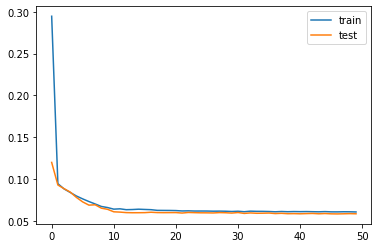

In [67]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [68]:
yhat_scaled=model.predict(test_X)
yhat_scaled=yhat_scaled.reshape(yhat_scaled.shape[0])
yhat_scaled.shape

(401,)

In [70]:
yhat = pd.DataFrame(yhat_scaled)
yhat = scaler.inverse_transform(yhat)
t_y = pd.DataFrame(test_y)
t_y = scaler.inverse_transform(t_y)

[]

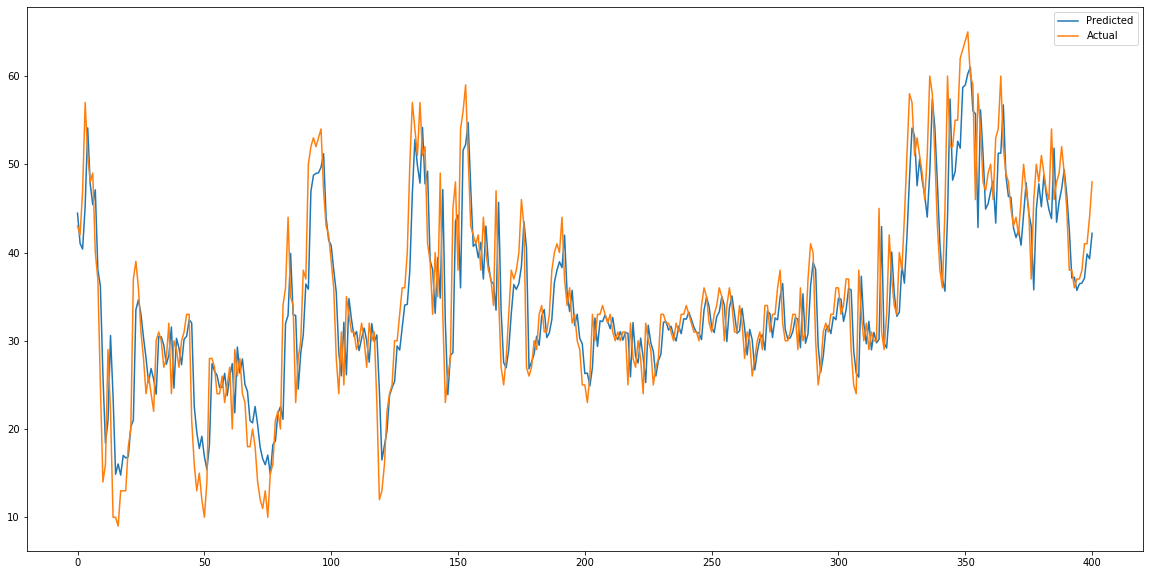

In [71]:
plt.figure(figsize=(20,10))
plt.plot(yhat, label="Predicted")
plt.plot(t_y, label = "Actual")
plt.legend()
plt.plot()

[]

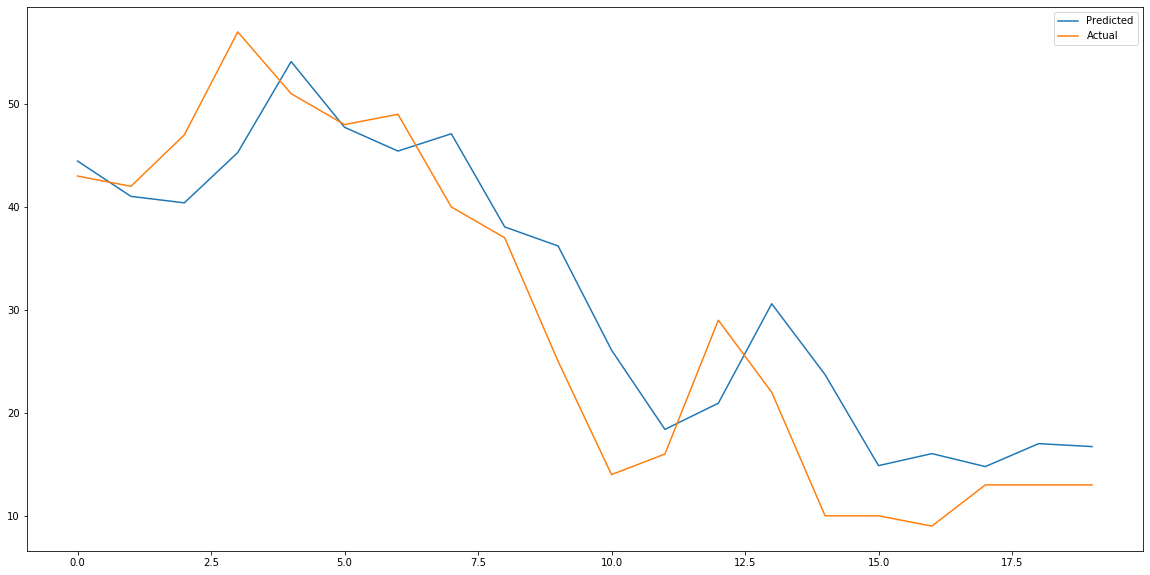

In [72]:
plt.figure(figsize=(20,10))
plt.plot(yhat[:20], label="Predicted")
plt.plot(t_y[:20], label = "Actual")
plt.legend()
plt.plot()

In [73]:
# calculate RMSE
rmse = sqrt(mean_squared_error(t_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5.046


In [102]:
yhat_comp = np.zeros(len(values))
yhat_comp[:] = np.nan
yhat_comp[n_train:]=np.ravel(yhat)

array([        nan,         nan,         nan, ..., 39.83065808,
       39.29033405, 42.17616403])

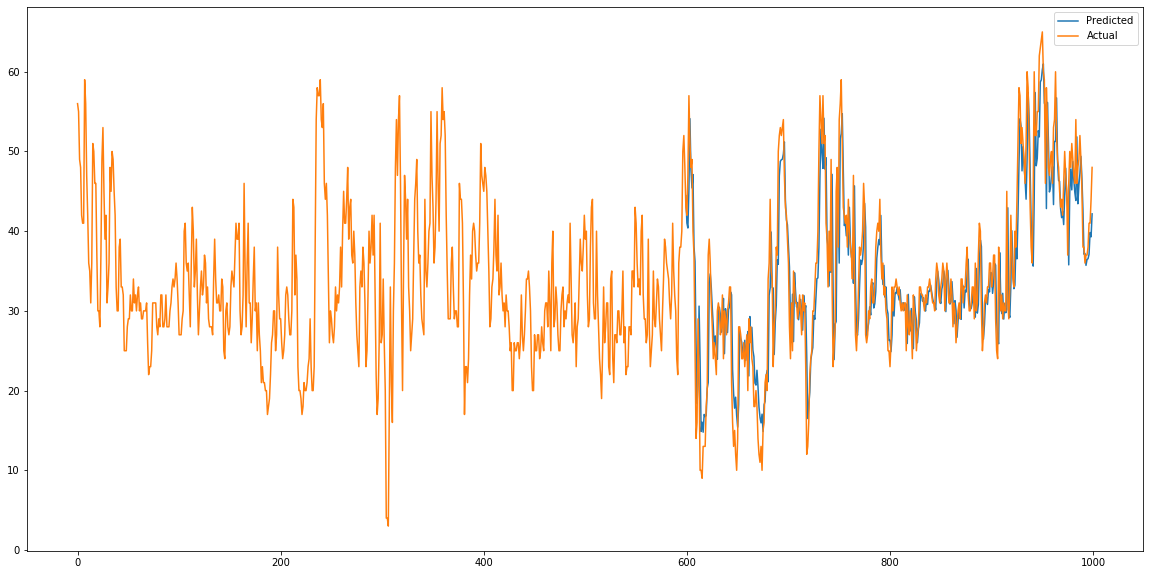

In [104]:
plt.figure(figsize = (20,10))
plt.plot(yhat_comp[-1000:], label = "Predicted")
plt.plot(dew.values[-1000:,0], label = "Actual")
plt.legend(loc="best")

In [182]:
dew_date_data = Riyadh_weather[['date','Dew_Point_Avg']].loc[10:]
dew_date_data['Predicted'] = yhat_comp
dew_date_data.tail()

,date,Dew_Point_Avg,Predicted
4011,2018-12-27,38,36.543702
4012,2018-12-28,41,37.102489
4013,2018-12-29,41,39.830658
4014,2018-12-30,44,39.290334
4015,2018-12-31,48,42.176164


In [185]:
dew_date_data['date'] = pd.to_datetime(dew_date_data['date'])

p = figure(plot_width=900, plot_height=500, x_axis_type="datetime")

p.line(dew_date_data['date'], dew_date_data['Dew_Point_Avg'], color='navy', alpha=0.5)
p.line(dew_date_data['date'], dew_date_data['Predicted'], color='red', alpha=0.5)

show(p)

In [133]:
import pickle

In [160]:
pickle.dump(scaler, open('scaler.pkl', 'wb'))

In [187]:
!pip freeze

absl-py==0.8.1
alabaster==0.7.12
anaconda-client==1.7.2
anaconda-navigator==1.9.7
anaconda-project==0.8.3
appnope==0.1.0
appscript==1.0.1
asn1crypto==0.24.0
astor==0.8.0
astroid==2.2.5
astropy==3.2.1
atomicwrites==1.3.0
attrs==19.1.0
awscli==1.16.276
Babel==2.7.0
backcall==0.1.0
backports.functools-lru-cache==1.5
backports.os==0.1.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
beautifulsoup4==4.7.1
bitarray==0.9.3
bkcharts==0.2
bleach==3.1.0
bokeh==1.2.0
boto==2.49.0
botocore==1.13.12
Bottleneck==1.2.1
cachetools==3.1.1
certifi==2019.6.16
cffi==1.12.3
chardet==3.0.4
Click==7.0
cloudpickle==1.2.1
clyent==1.2.2
colorama==0.4.1
conda==4.7.10
conda-build==3.18.8
conda-package-handling==1.3.11
conda-verify==3.4.2
contextlib2==0.5.5
cryptography==2.7
cycler==0.10.0
Cython==0.29.12
cytoolz==0.10.0
dask==2.1.0
decorator==4.4.0
defusedxml==0.6.0
distributed==2.1.0
docker==4.1.0
docutils==0.14
entrypoints==0.3
et-xmlfile==1.0.1
fastcache==1.1.0
f

In [158]:

features = '30.99999998, 13.99999997, 12.00000008, \
            10.00000019, 12.99999971, 36.00000002, 51.00000014, \
            44.99999984, 37.00000028, 32.99999987'.split(',')#request.form.values().split(',')
final_features = np.array(features).reshape(-1,1)
final_features = scaler.transform(final_features)
final_features = final_features.reshape(1,1,10)
prediction = model.predict(final_features)
prediction = scaler.inverse_transform(prediction)
output = np.round(prediction[0], 2)

In [159]:
output

array([31.28], dtype=float32)

In [153]:
values[1]

array([0.50793651, 0.46031746, 0.19047619, 0.15873016, 0.12698413,
       0.17460317, 0.53968254, 0.77777778, 0.68253968, 0.55555556,
       0.49206349])